# Network Analysis of ERP Components

Analyze the network of ERP papers - based on connections of papers that discuss multiple ERPs.

This network analysis is based on inferring connections based on articles that discuss multiple components (based on matching article IDs). 

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import networkx as nx

from lisc.utils import SCDB, load_object

In [2]:
import seaborn as sns
sns.set_context('talk')

In [3]:
# Import custom project code
import sys
sys.path.append('../code')
from plts import plot_count_hist, plot_network

## Setup

In [4]:
# Settings
SAVE_FIG = False
SAVE_EXT = '.pdf'

In [5]:
# Set the name of the file to load
name = 'erp' # 'erps', 'test'

# Set the minimum number of papers for including a component
n_min = 150

In [6]:
# Set the file locations
db = SCDB('../data/')
figs_dir = '../data/figures/network/'

In [7]:
# Load data
words = load_object('words_' + name, directory=db, reload_results=True)

In [8]:
# Drop components without enough articles
words.drop_data(n_min)

In [9]:
# Check how many ERP components were kept
print('Number of components kept: {}'.format(len(words.results)))

Number of components kept: 11


## Set up Network

In [10]:
# Settings for setting up the network
normalize = True
seed = 28

In [11]:
# Calculate the connections between components, based on overlapping articles
overlaps = np.zeros(shape=(words.n_terms, words.n_terms))
for ii, ei in enumerate(words.labels):
    for jj, ej in enumerate(words.labels):
        if ii == jj: continue
        overlaps[ii, jj] = len(set(words[ei].ids) & set(words[ej].ids))
        if normalize:
            overlaps[ii, jj] = overlaps[ii, jj] / len(set(words[ei].ids + words[ej].ids))

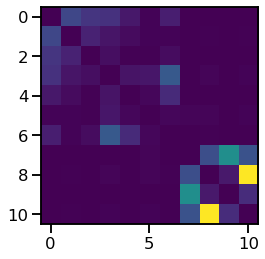

In [12]:
# Plot the weights matrix
plt.imshow(overlaps)

In [13]:
# Initialize network graph, and add the nodes
network = nx.Graph()
for ind, erp in enumerate(words.labels):
    network.add_node(ind)

In [14]:
# Add weighted edges between nodes
for ii in range(words.n_terms):
    for jj in range(words.n_terms):
        if ii == jj: continue
        if overlaps[ii, jj] > 0:
            network.add_edge(ii, jj, weight=overlaps[ii, jj])

In [15]:
# Collect the labels for each node
labels = {ind : label for ind, label in enumerate(words.labels)}

In [16]:
# Check for nodes with no connections, and set to drop
no_edges = [key for key, val in network.degree if val <= 1]

In [17]:
# Check the nodes that are disconnected from the network
drop_labels = [labels[ind] for ind in no_edges]
print('Disconnected nodes to drop: ', ' , '.join(drop_labels))

Disconnected nodes to drop:  


In [18]:
# Drop disconnected ERPs: components without connections to the network are dropped
for ind in [words.get_index(erp) for erp in drop_labels]:
    network.remove_node(ind)
    labels.pop(ind)

In [19]:
# Check the number of nodes left in the network
print('Number of nodes in the network: {}'.format(len(network.nodes)))

Number of nodes in the network: 11


### Plot the ERP network

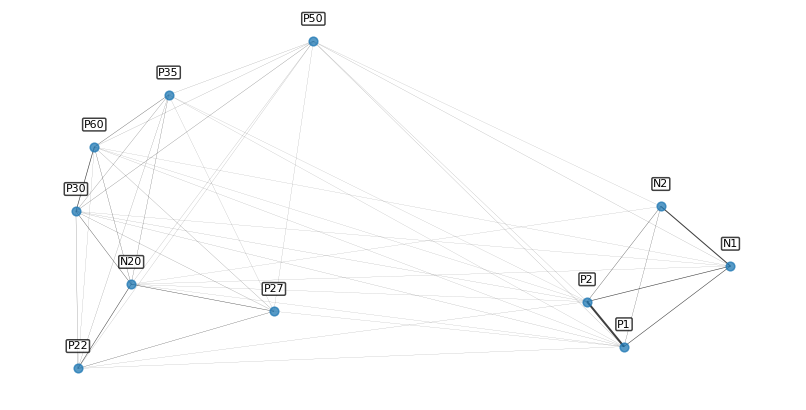

In [20]:
# Plot the network
plot_network(network, labels, layout_seed=seed, figsize=(11, 5.5),
             save_fig=SAVE_FIG, file_name='erp_network' + SAVE_EXT,
             directory=figs_dir, save_kwargs={'transparent' : True})

## Measures

Evaluate some descriptive measures of the ERP network.

In [21]:
# Check the total number of possible connections
n_pos_connections = int((len(network) * len(network) - len(network)) / 2)
print('The number of possible connections is: {}'.format(n_pos_connections))

The number of possible connections is: 55


In [22]:
# Get the number of edges
n_edges = len(network.edges)
print('The number of network edges is: {}'.format(n_edges))

The number of network edges is: 46


In [23]:
edge_proportion = n_edges / n_pos_connections
print('The percentage of possible edges: {:2.2f} %'.format(edge_proportion * 100))

The percentage of possible edges: 83.64 %


### Network Center

Calculate eccentricity and radius of the network:
- the eccentricity of a node is the maximum distance from the node to all other nodes. 
- the radius is the minimum eccentricity

Find the 'center' of the network - the node(s) with eccentricity equal to radius.

In [24]:
# Check network eccentricity and radius
print('Average eccentricity: \t {:2.2f}'.format(np.mean(list(nx.eccentricity(network).values()))))
print('Network radius: \t', nx.radius(network))

Average eccentricity: 	 1.73
Network radius: 	 1


In [25]:
# Check center(s)
centers = nx.center(network)
print('Network center(s): ', ', '.join([labels[ind] for ind in centers]))

Network center(s):  N20, P50, P1


### Descriptive Statistics

Check some descriptive measures of the network.

In [26]:
# Check some descriptive statistics of the network
print('Average clustering: \t\t{:1.2f}'.format(nx.average_clustering(network)))
print('Average node connectivity: \t{:1.2f}'.format(nx.average_node_connectivity(network)))
print('Average shortest path length: \t{:1.2f}'.format(nx.average_shortest_path_length(network)))

Average clustering: 		0.89
Average node connectivity: 	7.31
Average shortest path length: 	1.16


### Network Degree

The degree is the number of connections each node has to other nodes. 

In [27]:
# Check average degree
degrees = [val for key, val in network.degree]
print('Average degree: \t\t{:1.2f}'.format(np.median(degrees)))

Average degree: 		9.00


### Edge Weights

Check details and descriptions of the edge weights.

In [28]:
# Check the strongest weight between two nodes
topa = max(dict(network.edges).items(), key=lambda x: x[1]['weight'])
print('Top association: {} & {} - {:1.4f}'.format(labels[topa[0][0]], labels[topa[0][1]], topa[1]['weight']))

Top association: P1 & P2 - 0.2001


In [29]:
# Collect the distribution of all weights
all_weights = []
for edge in network.edges:
    all_weights.append(network.edges[edge]['weight'])
print('Average weight value: {:4.4f}'.format(np.median(all_weights)))

Average weight value: 0.0031


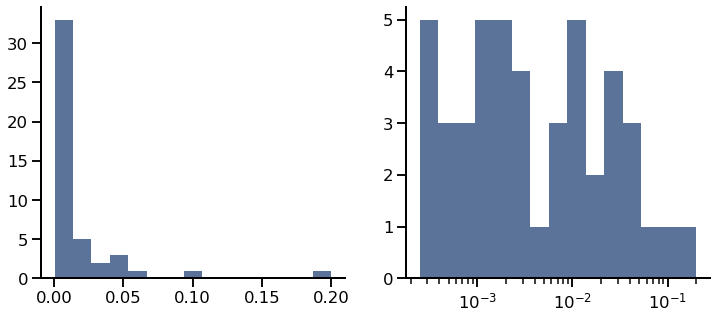

In [30]:
# Plot the distibution of weights, in linear & log spacing
_, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_count_hist(all_weights, bins=15, log=False, ax=axes[0])
plot_count_hist(all_weights, bins=15, log=True, ax=axes[1])

In [31]:
# Collect the set of weights per node
node_weights = []
for node_ind in network.nodes:
    node_edges = [edge for edge in network.edges() if node_ind in edge]
    node_weights.append([network[ne[0]][ne[1]]['weight'] for ne in node_edges])

In [32]:
# Collect the strongest link per node 
max_weight = []
for ind in labels.keys():
    max_ind = max(dict(network[ind]).items(), key=lambda x: x[1]['weight'])[0]
    max_weight.append(labels[max_ind])

### Measures per node

Check measures of interest for each node.

In [33]:
# Check measures per node
print("LABEL\t\tDEGREE\t\tAVG_WEIGHT (  MIN  -  MAX  )\t\tTOP-WEIGHT")
for label, degree, weights, top in zip(labels.values(), degrees, node_weights, max_weight):
    print('{:5s}\t\t{:2d}\t\t{:5.2f}\t   ({:1.4f} - {:3.4f})\t\t{:5s}'.format(\
        label, degree, np.mean(weights), min(weights), max(weights), top))

LABEL		DEGREE		AVG_WEIGHT (  MIN  -  MAX  )		TOP-WEIGHT
N20  		10		 0.01	   (0.0004 - 0.0423)		P22  
P22  		 8		 0.01	   (0.0011 - 0.0423)		N20  
P27  		 7		 0.01	   (0.0004 - 0.0309)		N20  
P30  		 9		 0.01	   (0.0002 - 0.0561)		P60  
P35  		 8		 0.01	   (0.0003 - 0.0237)		P60  
P50  		10		 0.00	   (0.0007 - 0.0123)		P30  
P60  		 9		 0.01	   (0.0003 - 0.0561)		P30  
N1   		 7		 0.03	   (0.0002 - 0.0990)		N2   
P1   		10		 0.03	   (0.0004 - 0.2001)		P2   
N2   		 5		 0.03	   (0.0004 - 0.0990)		N1   
P2   		 9		 0.03	   (0.0003 - 0.2001)		P1   
